# Seller analysis and segmentation

The goal of this notebook is to examine the leads and sellers at Olist and segment them so that in the future, sales representatives can focus on the right leads. The segmentation of the sellers could also improve Olist's understanding of their customers (i.e. sellers) and give new possibilities in defining subscription packages for the different sellers. 

In addition to clustering will model the seller's time between the date they signed up at Olist and their first sale with survival analysis. In the future Olist could use the survival function predictions in improving the estimates on when the seller will start creating revenue and for example anticipate growing need for logistic partners.

NOTE: 
In the beginning the idea was to either predict whether a deal will close or not, or to predict the revenues of a seller based on lead information so that Olist would know which leads to focus on. During the descriptive part we found out that there are not enough features to predict which deals will close. For predicting revenues, it was difficult to find features that had correlation with the target variable. After examining the possibility for predicting revenues, it was found that not all of the sellers in the closed deal dataset even had sale. This is why the focus moved towards predicting the time to first sale. These iterations were excluded from the final notebook for clarity.

## 1. Understanding the marketing funnel dataset

First we want to understand the MQL dataset and the closed deals dataset. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime


%matplotlib inline

In [2]:
df_closed = pd.read_csv('olist_closed_deals_dataset.csv')
df_leads = pd.read_csv('olist_marketing_qualified_leads_dataset.csv')

In [3]:
df_leads.head()

,mql_id,first_contact_date,landing_page_id,origin
0,dac32acd4db4c29c230538b72f8dd87d,2018-02-01,88740e65d5d6b056e0cda098e1ea6313,social
1,8c18d1de7f67e60dbd64e3c07d7e9d5d,2017-10-20,007f9098284a86ee80ddeb25d53e0af8,paid_search
2,b4bc852d233dfefc5131f593b538befa,2018-03-22,a7982125ff7aa3b2054c6e44f9d28522,organic_search
3,6be030b81c75970747525b843c1ef4f8,2018-01-22,d45d558f0daeecf3cccdffe3c59684aa,email
4,5420aad7fec3549a85876ba1c529bd84,2018-02-21,b48ec5f3b04e9068441002a19df93c6c,organic_search


In [4]:
df_closed.head()

,mql_id,seller_id,sdr_id,sr_id,won_date,business_segment,lead_type,lead_behaviour_profile,has_company,has_gtin,average_stock,business_type,declared_product_catalog_size,declared_monthly_revenue
0,5420aad7fec3549a85876ba1c529bd84,2c43fb513632d29b3b58df74816f1b06,a8387c01a09e99ce014107505b92388c,4ef15afb4b2723d8f3d81e51ec7afefe,2018-02-26 19:58:54,pet,online_medium,cat,NaN,NaN,NaN,reseller,NaN,0.0
1,a555fb36b9368110ede0f043dfc3b9a0,bbb7d7893a450660432ea6652310ebb7,09285259593c61296eef10c734121d5b,d3d1e91a157ea7f90548eef82f1955e3,2018-05-08 20:17:59,car_accessories,industry,eagle,NaN,NaN,NaN,reseller,NaN,0.0
2,327174d3648a2d047e8940d7d15204ca,612170e34b97004b3ba37eae81836b4c,b90f87164b5f8c2cfa5c8572834dbe3f,6565aa9ce3178a5caf6171827af3a9ba,2018-06-05 17:27:23,home_appliances,online_big,cat,NaN,NaN,NaN,reseller,NaN,0.0
3,f5fee8f7da74f4887f5bcae2bafb6dd6,21e1781e36faf92725dde4730a88ca0f,56bf83c4bb35763a51c2baab501b4c67,d3d1e91a157ea7f90548eef82f1955e3,2018-01-17 13:51:03,food_drink,online_small,NaN,NaN,NaN,NaN,reseller,NaN,0.0
4,ffe640179b554e295c167a2f6be528e0,ed8cb7b190ceb6067227478e48cf8dde,4b339f9567d060bcea4f5136b9f5949e,d3d1e91a157ea7f90548eef82f1955e3,2018-07-03 20:17:45,home_appliances,industry,wolf,NaN,NaN,NaN,manufacturer,NaN,0.0


In [5]:
print('Closed deals:',len(df_closed))
print('All leads: ', len(df_leads))
print('Rows with no NAs:', len(df_closed.dropna()))

Closed deals: 842
All leads:  8000
Rows with no NAs: 38


There are quite many NAs in the closed deal dataframe, which is probably because these fields were not mandatory for the new seller to fill. We will not use these rows in our analysis. In addition, we will disregard the sdr_id and sr_id, because looking at the performance of each representative is not in the scope of the analysis. In addtion, we will create a new dataframe that's a combination of the closed deals and lead information.

Let's also add a few other useful columns to our leads dataset.

In [6]:
df_leads['closed'] = np.where(df_leads.mql_id.isin(df_closed.mql_id), 'yes', 'no')

# Add a 'year-month' column
df_leads['first_contact_date'] = pd.to_datetime(df_leads['first_contact_date'])
df_leads['first_contact_date(y-m)'] = df_leads['first_contact_date'].dt.to_period('M')

In [7]:
data_sellers = df_closed.copy()

del data_sellers['has_gtin']
del data_sellers['average_stock']
del data_sellers['declared_product_catalog_size']
del data_sellers['declared_monthly_revenue']
del data_sellers['has_company']
del data_sellers['sdr_id']
del data_sellers['sr_id']

In [8]:
data_sellers = pd.merge(data_sellers, df_leads, on="mql_id", how='left')

In [9]:
del data_sellers['mql_id']
del data_sellers['landing_page_id']
del data_sellers['closed']
data_sellers.head()

,seller_id,won_date,business_segment,lead_type,lead_behaviour_profile,business_type,first_contact_date,origin,first_contact_date(y-m)
0,2c43fb513632d29b3b58df74816f1b06,2018-02-26 19:58:54,pet,online_medium,cat,reseller,2018-02-21,organic_search,2018-02
1,bbb7d7893a450660432ea6652310ebb7,2018-05-08 20:17:59,car_accessories,industry,eagle,reseller,2018-04-04,referral,2018-04
2,612170e34b97004b3ba37eae81836b4c,2018-06-05 17:27:23,home_appliances,online_big,cat,reseller,2018-04-03,organic_search,2018-04
3,21e1781e36faf92725dde4730a88ca0f,2018-01-17 13:51:03,food_drink,online_small,NaN,reseller,2018-01-14,paid_search,2018-01
4,ed8cb7b190ceb6067227478e48cf8dde,2018-07-03 20:17:45,home_appliances,industry,wolf,manufacturer,2017-10-09,unknown,2017-10


### Acquiring leads and closing deals
First we will look at the contacted leads and won deals as a time series to understand the trends at Olist. Then we will have a closer look at where the lead was acquired, i.e. the "origin" of the lead.

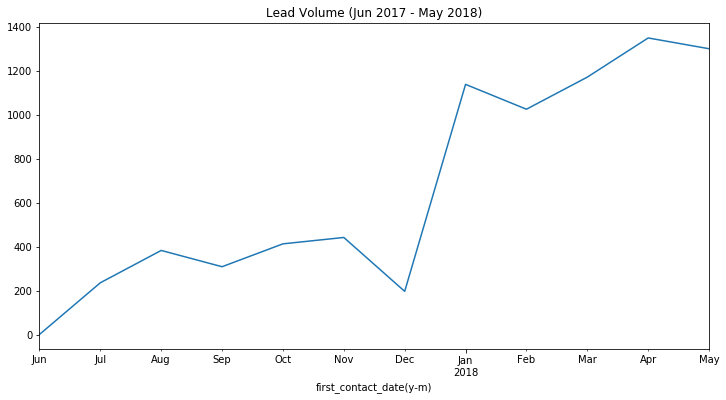

In [10]:
monthly_leads = df_leads.groupby(by='first_contact_date(y-m)').mql_id.count()

monthly_leads.plot.line(figsize=(12, 6))
plt.title('Lead Volume (Jun 2017 - May 2018)');
plt.savefig('lead_volume.png')

In [11]:
data_sellers['won_date'] = pd.to_datetime(data_sellers['won_date'])
data_sellers['won_date(y-m)'] = data_sellers['won_date'].dt.to_period('M')
monthly_cd = data_sellers.groupby('won_date(y-m)')['seller_id'].count()
monthly_contact = data_sellers.groupby('first_contact_date(y-m)')['seller_id'].count()
#monthly_cd.to_frame().T

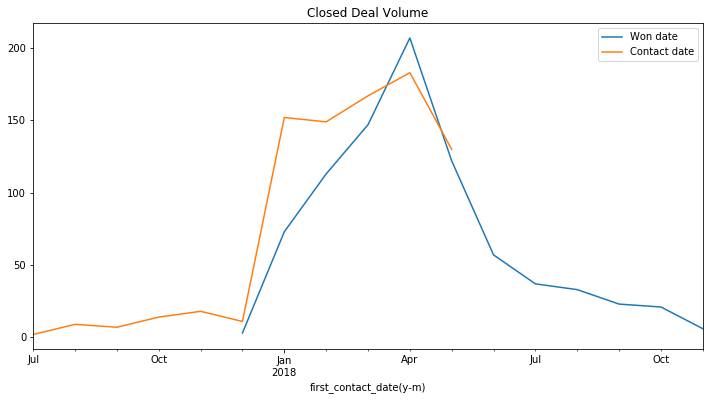

In [12]:
monthly_cd.plot.line(figsize=(12, 6), label = 'Won date')
monthly_contact.plot.line(figsize = (12,6), label = 'Contact date')
plt.legend()
plt.title('Closed Deal Volume');

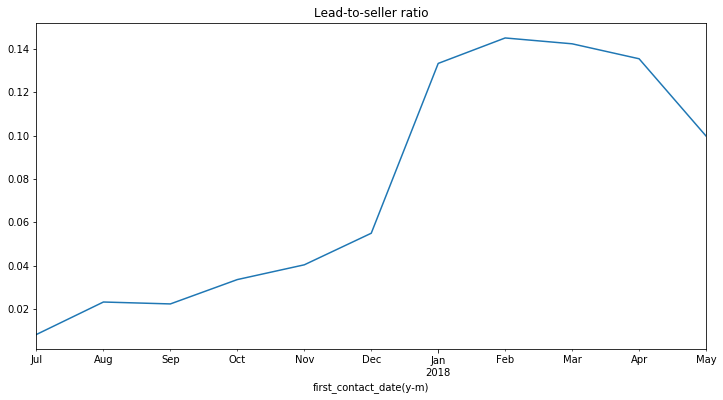

In [13]:
monthly_ratio = monthly_contact/monthly_leads[1:]
monthly_ratio.plot.line(figsize = (12,6))
plt.title('Lead-to-seller ratio');

We can see from the the three charts that both lead volume and closed deal volume has increased dramatically in 2018. In addition, we can see that the file contains data for a full year, from mid 2017 to mid 2018.

Let's have a quick look at the time it takes for a deal to close.

In [14]:

data_sellers['days_to_close'] = (data_sellers['won_date'] - data_sellers['first_contact_date']) \
                                                                    .astype('timedelta64[D]')
data_sellers = data_sellers.dropna()

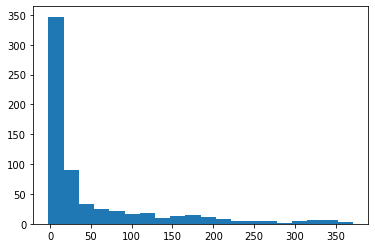

In [15]:
plt.hist(data_sellers['days_to_close'], bins = 20)
plt.show()

The histogram for days_to_close seems to be decreasing expontentially. 

Let's now have a more detailed look at the origin of the leads. 

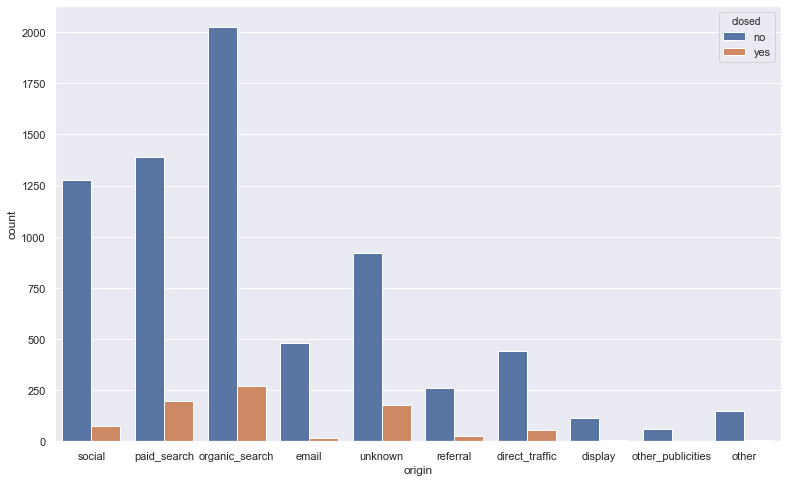

In [16]:
import seaborn as sns
sns.set(style="darkgrid")
fig = plt.figure(figsize = (13,8))
ax = sns.countplot(x='origin', hue = 'closed', data=df_leads)

Origin means the type of media where the lead was acquired. We can see that most of the leads are acquired through organic search, paid search and social networks. Has the performance of different channels changed over time? To understand this we will plot the timeseries of the closed deals grouped by the origin of the lead.

In [17]:
cols = data_sellers.groupby(by='origin') \
           .seller_id \
           .count() \
           .sort_values(ascending=False) \
           .index

monthly_cd_origin = data_sellers.groupby(['first_contact_date(y-m)', 'origin']) \
                              .seller_id \
                              .count() \
                              .unstack(level=1, fill_value=0)

monthly_cd_origin = monthly_cd_origin[cols]

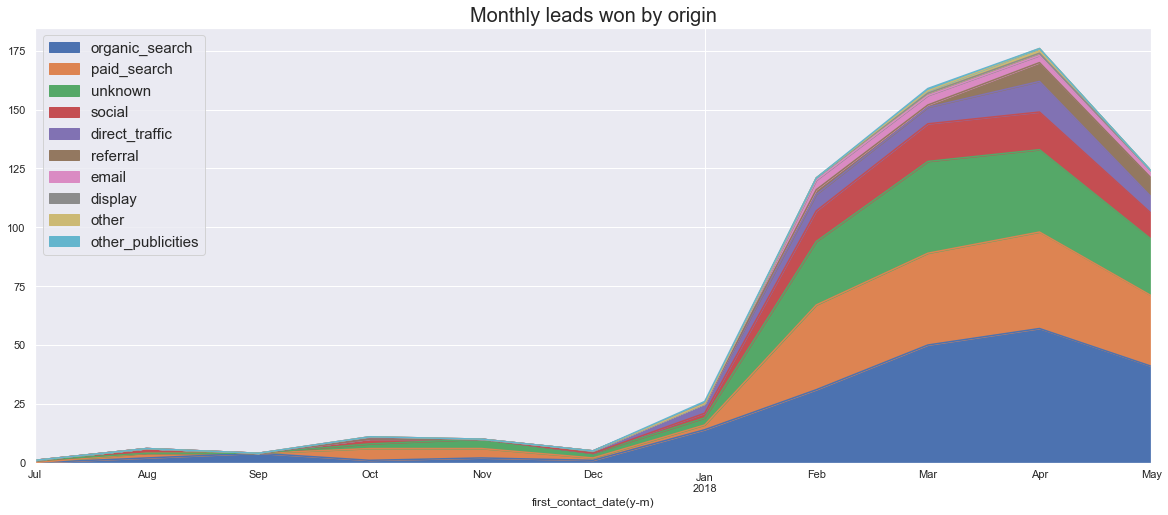

In [18]:
# Plot the monthly contacts by origin
monthly_cd_origin.plot.area(figsize=(20,8))

plt.title('Monthly leads won by origin', fontsize=20)
#plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));
plt.legend(loc='upper left', fontsize = 15);
plt.savefig('closed_deal_volume.png')
plt.show()

It seems like the performance of most of the different channels has increased, but especially from organic search, paid search and direct traffic. This would hint that Olist has been doing a better job in marketing in 2018, since more possible sellers are finding their way to the sign-up website organically. 

### Categorical variables

Let's have a quick look at the lead behaviour profile, business segment and lead type to see if we can simplify the categories a bit and even out the distributions. The lead behaviour profile is an interesting variable, and it's probably the sales representative's take on how active the lead is and how the communication works. 

The business segment is probably the main focus segment of the seller. We will group several segments together to form business sectors. 

The lead type is also an interesting variable with quite an uneven distribution between different categories, so we will group some of the lead types together. 

In [19]:
data_sellers['lead_behaviour_profile'].value_counts()
#665 rows have values, total number of rows is over 800...

cat            391
eagle          120
wolf            93
shark           23
cat, wolf        8
eagle, wolf      3
eagle, cat       3
shark, cat       1
shark, wolf      1
Name: lead_behaviour_profile, dtype: int64

In [20]:
profile_list = ['cat', 'eagle', 'wolf', 'shark']
data_sellers['lead_behaviour_profile'] = data_sellers.lead_behaviour_profile \
                                                      .map(lambda profile: profile
                                                           if profile in profile_list
                                                           else 'others')

In [21]:
#defining which business segments are in each sector
home = ['home_decor', 'household_utilities', 'bed_bath_table', 'home_office_furniture', 'home_appliances',
       'small_appliances']

free_time = ['sports_leisure', 'toys', 'stationery', 'music_instruments', 'books', 'party', 'gifts' ]
accessories = ['bags_backpacks', 'fashion_accessories', 'watches']
electronics = ['audio_video_electronics','computers', 'phone_mobile']
construction = ['car_accessories', 'construction_tools_house_garden', 'air_conditioning']
food = ['food_drink', 'food_supplement']
other = ['pet', 'baby', 'handcrafted']
beauty = ['health_beauty']

In [22]:
#creating a new sector column and setting the value based on business segment
data_sellers['sector'] = 'other'

sectors = [home, free_time, accessories, electronics, construction, food, beauty, other]
sector_names = ['home', 'free_time', 'accessories', 'electronics', 'construction', 'food', 'beauty', 'other']

for i in range(len(sectors)):
    data_sellers['sector'] = np.where(data_sellers.business_segment.isin(sectors[i]), sector_names[i], data_sellers.sector)

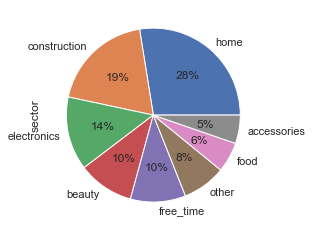

In [23]:
data_sellers['sector'].value_counts().plot(kind='pie', autopct='%1.0f%%');

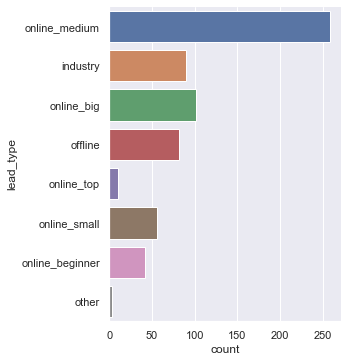

In [24]:
sns.catplot(y="lead_type", kind="count", data=data_sellers);


In [25]:
data_sellers = data_sellers[data_sellers.lead_type != 'other']
data_sellers.loc[data_sellers.lead_type == 'online_top', 'lead_type'] = 'online_big'
data_sellers.loc[data_sellers.lead_type == 'online_beginner', 'lead_type'] = 'online_small'

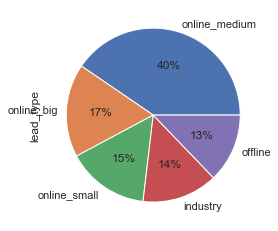

In [26]:
data_sellers.lead_type.value_counts().plot(kind='pie', autopct='%1.0f%%');


## 2. Preparing order data
Next let's upload a few more of the interesting datasets that give us an understanding of the performance of the seller. This data includes more sellers than our MQL-data, because many of the sellers have been in the system for longer than since mid 2017. 

In [27]:
df_orders = pd.read_csv('olist_order_items_dataset.csv')
df_orders2 = pd.read_csv('olist_orders_dataset.csv')
df_reviews = pd.read_csv('olist_order_reviews_dataset.csv')
df_items = pd.read_csv('olist_products_dataset.csv')
df_translations = pd.read_csv('product_category_name_translation.csv')

In [28]:
orders = pd.merge(df_orders, df_reviews[['order_id', 'review_score']], on="order_id", how = 'left')
orders = pd.merge(orders, df_orders2[['order_id', 'order_status', 'order_purchase_timestamp']], on = 'order_id', how = 'left')
orders = pd.merge(orders, df_items[['product_id', 'product_category_name']], on='product_id', how='left')
orders = pd.merge(orders, df_translations, on= 'product_category_name', how = 'left')
del orders['product_category_name']

In [29]:
orders.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,review_score,order_status,order_purchase_timestamp,product_category_name_english
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,5,delivered,2017-09-13 08:59:02,cool_stuff
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,4,delivered,2017-04-26 10:53:06,pet_shop
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,5,delivered,2018-01-14 14:33:31,furniture_decor
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,4,delivered,2018-08-08 10:00:35,perfumery
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,5,delivered,2017-02-04 13:57:51,garden_tools


In [30]:
orders['order_status'].value_counts()

delivered      110848
shipped          1196
canceled          546
invoiced          364
processing        358
unavailable         7
approved            3
Name: order_status, dtype: int64

We don't need the information about canceled orders so we will exclude that from the dataset. We will also add some helpful columns and set the date of the order as the index. 

In [31]:
orders = orders[orders.order_status != 'canceled']
orders = orders.dropna()

In [32]:
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['date'] = orders['order_purchase_timestamp']
orders = orders.set_index('order_purchase_timestamp')
orders['qty'] = 1

Next we'll define some new columns that will be helpful comparing the different sellers. For each seller we want to calculate the following things:
- First sales date
- Average sales value and quantity per month
- Total sales value
- Number of months with sales
- Number of unique products sold
- Number of categories represented
- Average review score

In [33]:
first_sales_date = orders.groupby('seller_id')['date'].min().to_frame(name = 'first_sales_date').reset_index()
total_revenue = orders.groupby('seller_id')['price'].sum().to_frame(name = 'total_sales_value').reset_index()

In [34]:
monthly_sales = orders.groupby([pd.TimeGrouper(freq='M'), 'seller_id'])[['price', 'qty']].sum().reset_index()
monthly_sales.head()

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  """Entry point for launching an IPython kernel.


,order_purchase_timestamp,seller_id,price,qty
0,2016-09-30,1554a68530182680ad5c8b042c3ab563,72.89,2
1,2016-09-30,ecccfa2bb93b34a3bf033cc5d1dcdc69,134.97,3
2,2016-10-31,011b0eaba87386a2ae96a7d32bb531d1,99.98,2
3,2016-10-31,01cf7e3d21494c41fb86034f2e714fa1,69.90,1
4,2016-10-31,024b564ae893ce8e9bfa02c10a401ece,467.40,6


In [35]:
#number of months with sales
number_of_months = monthly_sales.groupby('seller_id').size().to_frame(name = 'months_with_sales').reset_index()

In [36]:
#monthly avg qty and avg value 
monthly_avg = monthly_sales.groupby('seller_id').mean().reset_index()
monthly_avg = monthly_avg.rename(columns = {'price':'avg_monthly_sales_value', 'qty':'avg_monthly_sales_qty'})

In [37]:
#avg review score
avg_review = orders.groupby('seller_id')['review_score'].mean().to_frame(name = 'review_score').reset_index()

In [38]:
#number of unique products
product_counts = orders.groupby(['seller_id', 'product_id']).size().to_frame(name = 'counts').reset_index()
unique_prods = product_counts['seller_id'].value_counts().to_frame(name = 'unique_products').reset_index()
unique_prods = unique_prods.rename(columns = {'index':'seller_id'})

In [39]:
#number of categories represented
category_counts = orders.groupby(['seller_id', 'product_category_name_english']).size().to_frame(name = 'counts').reset_index()
unique_cats = category_counts['seller_id'].value_counts().to_frame(name = 'unique_categories').reset_index()
unique_cats = unique_cats.rename(columns = {'index':'seller_id'})

In [40]:
#time to merge!!
#data = df_sellers.merge(unique_cats, on = 'seller_id', how = 'left')
data_combined = unique_cats.merge(unique_prods, on = 'seller_id', how = 'left')
data_combined = data_combined.merge(monthly_avg, on = 'seller_id', how = 'left')
data_combined = data_combined.merge(avg_review, on = 'seller_id', how = 'left')
data_combined = data_combined.merge(number_of_months, on = 'seller_id', how = 'left')
data_combined = data_combined.merge(first_sales_date, on = 'seller_id', how = 'left')
data_combined = data_combined.merge(total_revenue, on = 'seller_id', how = 'left')

full_sellers = data_combined.copy()

## 3.  Clustering the sellers based on order data
The plan is to cluster all sellers that have sold something based on the different attributes we defined in the previous section. This should give a better understanding of the segments of sellers, and allow us to see which type of seller is the most successful. Another option would be to cluster sellers based on the information provided in the MQL-dataset, but that dataset already includes categorisation of sellers based on their type and behaviour profile etc, so clustering might not give us additional value there. 

In [41]:
cols_clustering = ['unique_categories', 'unique_products', 'avg_monthly_sales_value', 'avg_monthly_sales_qty',
                  'review_score', 'months_with_sales', 'total_sales_value']
data_clustering = data_combined[cols_clustering]
data_clustering.head()

,unique_categories,unique_products,avg_monthly_sales_value,avg_monthly_sales_qty,review_score,months_with_sales,total_sales_value
0,27,180,2427.060952,17.095238,4.108635,21,50968.28
1,23,104,9659.264286,107.142857,4.038000,14,135229.70
2,23,135,2165.112857,20.809524,3.871854,21,45467.37
3,21,154,486.639444,18.277778,4.060790,18,8759.51
4,19,145,2525.940000,36.100000,4.199446,20,50518.80


In [42]:
#standardize the data to normal distribution
from sklearn import preprocessing
data_standardized = preprocessing.scale(data_clustering)
data_standardized = pd.DataFrame(data_standardized)

We will use KMeans clustering. Generally KMeans works best with 2D data, and the results are difficult to demonstrate if there are more dimensions. With KMeans, the number of clusters has to be defined upfront. We will do a simple silhoutte analysis to decide the number of clusters, and then we will calculate the final clusters. (inspired by https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py)

For n_clusters = 2 The average silhouette_score is : 0.7905326155509119
For n_clusters = 3 The average silhouette_score is : 0.6666689505581574
For n_clusters = 4 The average silhouette_score is : 0.6826290683228603
For n_clusters = 5 The average silhouette_score is : 0.6392910914280889
For n_clusters = 6 The average silhouette_score is : 0.5671215240667314


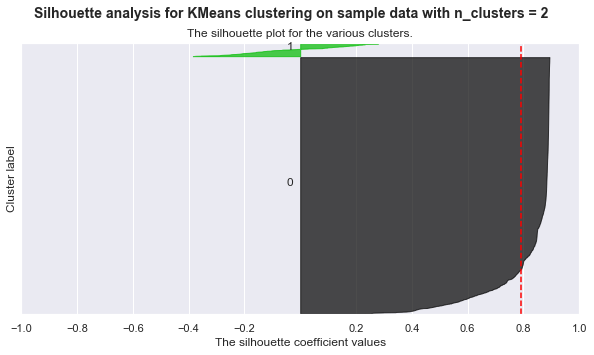

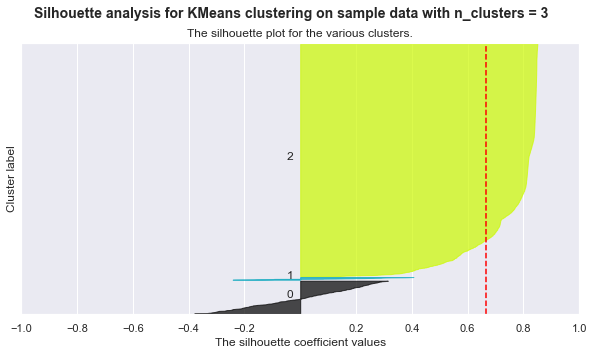

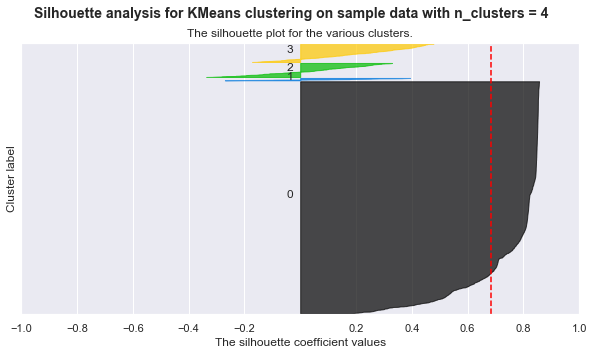

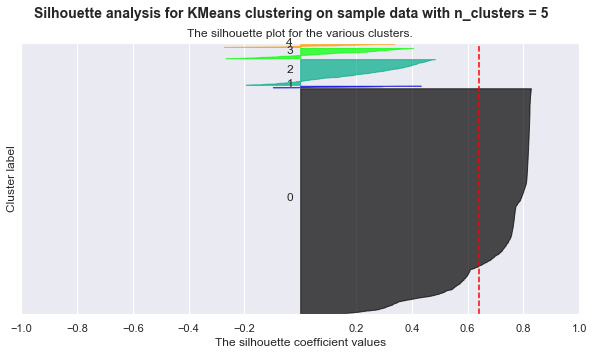

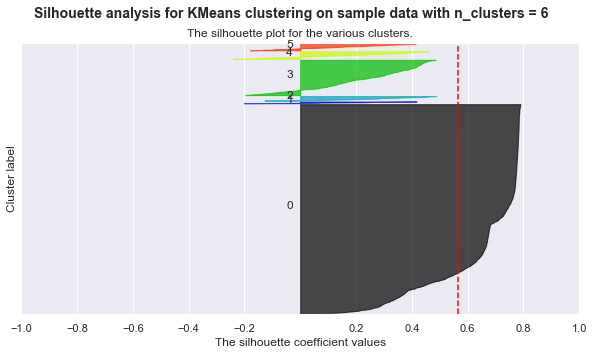

In [43]:
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
import matplotlib.cm as cm

#after testing different combinations, the columns the first 4 columns seems to give us the best clusters. 
X = data_standardized.loc[:, [0,1,2,3]]

range_n_clusters = [2,3,4,5,6]

for n_clusters in range_n_clusters:
    # Create the plot
    fig, ax1 = plt.subplots()
    fig.set_size_inches(10, 5)

    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-1, 1]
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-1, -0.8, -0.6, -0.4, -0.2, 0.2, 0.4, 0.6, 0.8, 1])


    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

With two clusters, the majority of the data is in one cluster, so even though the silhouette score is the highest, the clusters might not give us much information. The second highest silhouette score is with 4 clusters so we will use that. 

In [44]:
# Fitting K-Means to the dataset
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X)

#beginning of  the cluster numbering with 1 instead of 0
y_kmeans1=y_kmeans
y_kmeans1=y_kmeans+1

# New Dataframe called cluster
cluster = pd.DataFrame(y_kmeans1)

# Adding cluster column to the data-df
data_clustering['cluster'] = cluster
full_sellers['cluster'] = cluster

#Mean of clusters
kmeans_mean_cluster = pd.DataFrame(round(data_clustering.groupby('cluster').mean(),1))
kmeans_mean_cluster

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


,unique_categories,unique_products,avg_monthly_sales_value,avg_monthly_sales_qty,review_score,months_with_sales,total_sales_value
cluster,,,,,,,
1,1.6,5.8,328.4,2.5,4.0,4.5,1778.9
2,7.7,41.0,744.9,8.8,4.1,12.5,9905.8
3,5.9,160.2,7232.8,63.9,4.1,15.5,107798.4
4,2.4,35.9,2981.5,14.5,4.0,9.3,23904.6


## 4. Understanding the clusters
The next step is to understand what's really in each cluster, i.e. plotting the values of each of the clustering features and examining the different patterns. Then we will go a step further and plot also values of the other features we didn't use in the clustering, to see if the sellers in the clusters have other things in common. 

In [45]:
full_sellers = data_sellers.merge(full_sellers, on = 'seller_id', how = 'left')
full_sellers = full_sellers.dropna()
full_sellers.columns

Index(['seller_id', 'won_date', 'business_segment', 'lead_type',
       'lead_behaviour_profile', 'business_type', 'first_contact_date',
       'origin', 'first_contact_date(y-m)', 'won_date(y-m)', 'days_to_close',
       'sector', 'unique_categories', 'unique_products',
       'avg_monthly_sales_value', 'avg_monthly_sales_qty', 'review_score',
       'months_with_sales', 'first_sales_date', 'total_sales_value',
       'cluster'],
      dtype='object')

1    2600
2     208
4     158
3      27
Name: cluster, dtype: int64


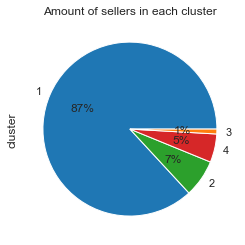

In [46]:
#Details of clusters for all sellers that have had sales
print(data_clustering['cluster'].value_counts())
data_clustering.cluster.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['tab:blue','tab:green','tab:red', 'tab:orange']);
plt.title('Amount of sellers in each cluster');
plt.savefig('sellers_clusters.png')


1.0    254
2.0     12
4.0     11
3.0      2
Name: cluster, dtype: int64


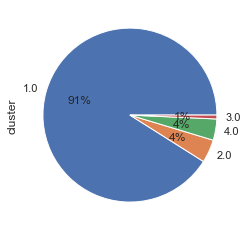

In [47]:
#Details of clusters for newly acquired sellers (included in MQL-dataset and has had sales)
print(full_sellers['cluster'].value_counts())
full_sellers.cluster.value_counts().plot(kind='pie', autopct='%1.0f%%');


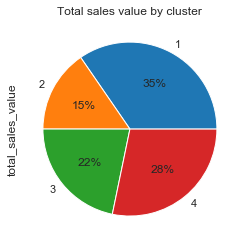

In [48]:
#Total sales by cluster
data_clustering.groupby('cluster')['total_sales_value'].sum().plot(kind='pie', autopct='%1.0f%%', colors=['tab:blue','tab:orange', 'tab:green','tab:red']);
plt.title('Total sales value by cluster');
plt.savefig('revenues_cluster.png')

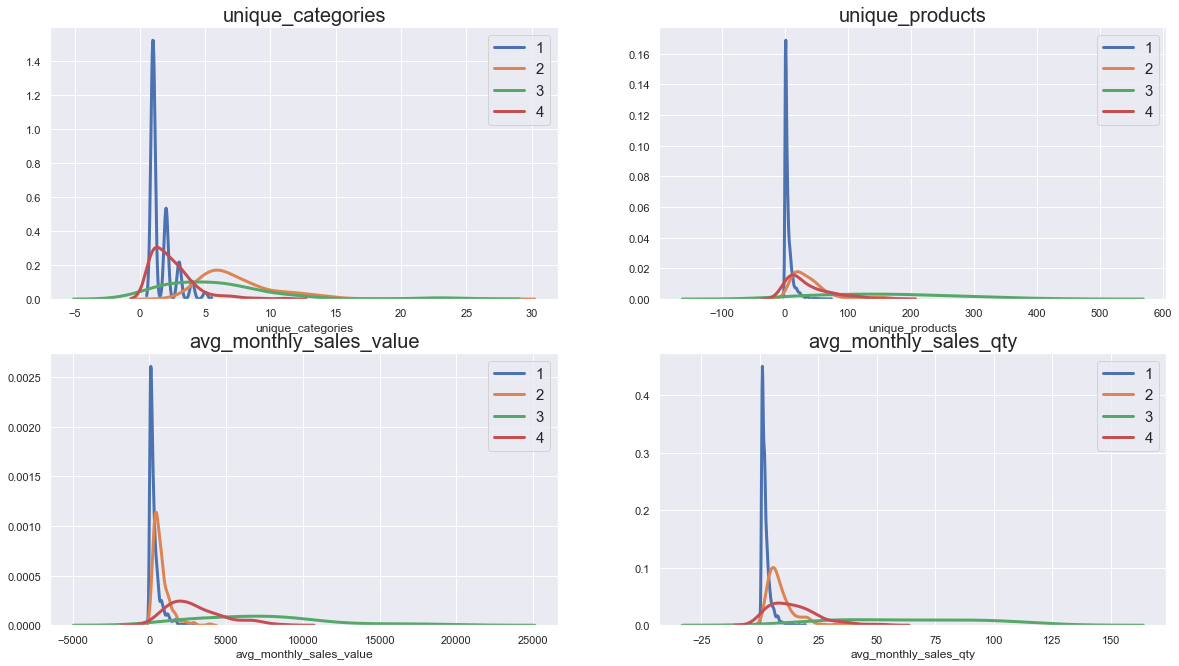

In [49]:
# List of clusters
clusters = [1,2,3,4]
cols = ['unique_categories', 'unique_products', 'avg_monthly_sales_value',
       'avg_monthly_sales_qty']

colors = ['blue','red', 'orange', 'green']

# Iterate through the clusters

fig = plt.figure(figsize = (20,11))

for i in range(len(cols)):
    plt.subplot(2,2,i+1)
    col = cols[i]
    
    for c in clusters:
        subset = data_clustering[data_clustering['cluster'] == c]
    
        # Draw the density plot
        sns.distplot(subset[col], hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = c)
    
    plt.title(cols[i], fontsize=20.)
    plt.legend(fontsize=15.)

plt.savefig('clusters.png')
plt.show()

The biggest cluster has smaller customers that have the smallest avg sales. This cluster includes 90% of the sellers, but provides only 35% of the total revenues. These are small/new sellers that only sell a few products and don't have that many sales. 

The smallest cluster only has a few sellers (1%), but provides 22% of the revenue. These are big sellers that have the biggest number of products, the highest average sales and average sales value. 

The two clusters in between both account for 4% of the sellers, but the other provides 15% of revenues while the other provides 30%. The latter actually has a more specified selection of categories, while the number of unique products is the same in the two. It seems like this focused strategy works well and this cluster seems to be very well performing.  

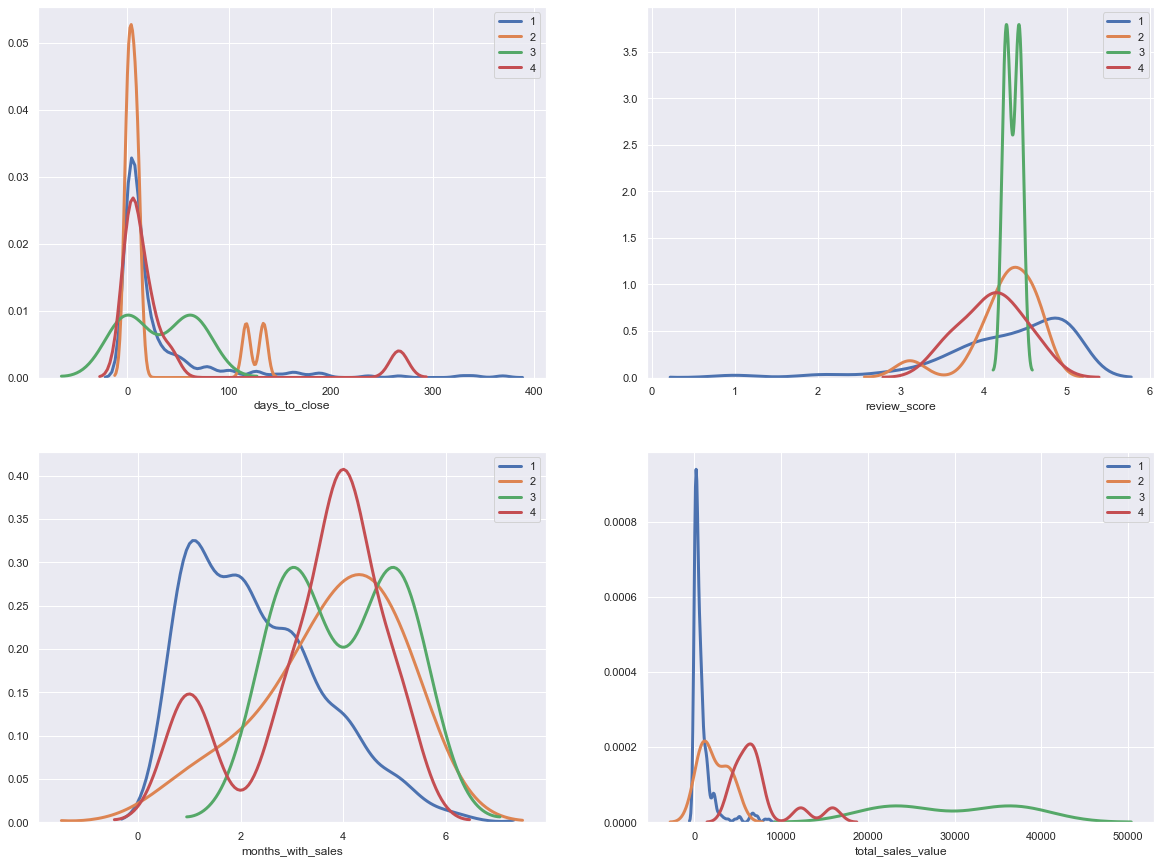

In [50]:
# List of clusters
clusters = [1,2,3,4]
cols = ['days_to_close', 'review_score', 'months_with_sales', 'total_sales_value']

# Iterate through the clusters

fig = plt.figure(figsize = (20,15))

for i in range(len(cols)):
    plt.subplot(2,2,i+1)
    col = cols[i]
    
    for c in clusters:
        subset = full_sellers[full_sellers['cluster'] == c]
    
        # Draw the density plot
        sns.distplot(subset[col], hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = c)
    
    #plt.title(cols[i])
    plt.legend()    

plt.savefig('clusters_extra.png')
plt.show()

In these charts we are only lookin at the sellers that are included in the MQL dataset, so the clusters have less sellers and for example cluster 2 has just 2 selles - therefore it's diffucult to make assumptions here. It seems like even though cluster 4 is more successful in terms of sales value in comparison to cluster 3, the distribution of the review scores is not as good. As we can ee from the months_with_sales chart, the biggest cluster (cluster 1) has the least months with sales, so our theory of that cluster having newer sellers seems to be correct.

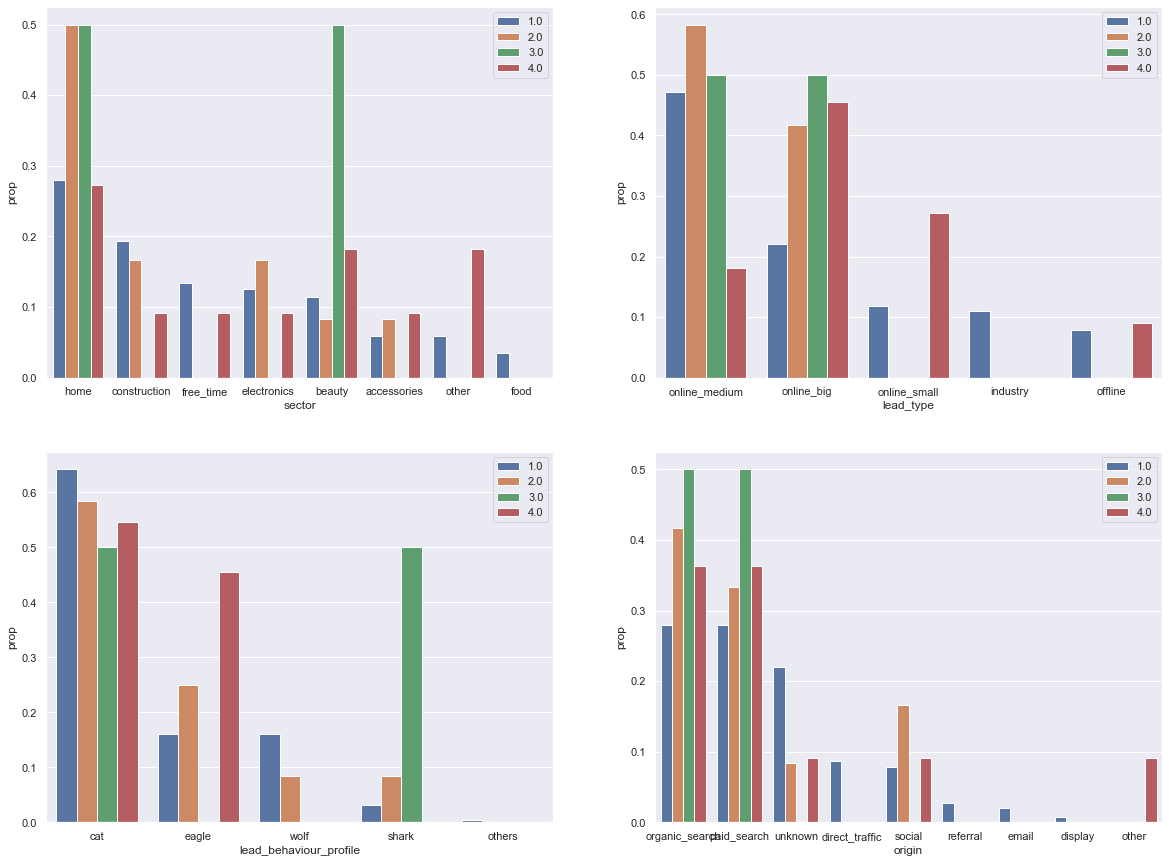

In [51]:
cols = ['sector', 'lead_type', 'lead_behaviour_profile',
       'origin']

fig = plt.figure(figsize = (20,15))

for i in range(len(cols)):
    plt.subplot(2,2,i+1)
    col = cols[i]
    
    y= "prop"
    
    prop_df = (full_sellers[col]
           .groupby(full_sellers['cluster'])
           .value_counts(normalize=True)
           .rename(y)
           .reset_index())
    
    ax = sns.barplot(x=col, y = y, hue="cluster", data=prop_df)    
    plt.legend(loc = 'upper right')
    
plt.savefig('clusters_categoricals.png')
plt.show()

Again we have to remember that this dataset is smaller, and the smallest cluster number 2 only has two sellers. However, from the lead types we can see that the successful medium cluster 4 has a majority of online_big sellers, while the less successful cluster 3 has a majority of online_medium sellers. Cluster 3 has also mostly home products, while cluster 4 includes sellers from a more diverese selection of sectors. 

## 5. Surivival analysis on "Time to first sale"

Being able to predict the time it takes for a seller to start making sales would be a valuable asset not only for the seller, but also Olist. With this information Olist could predict the workload of logistic partners and get an estimate on when the seller will actually start generating revenues. 

Let's first decide the time and event parameters:
- Time = number of days the seller has been on Olist, i.e. the days between won_date and "today", or days between won_date and first sales date
    - Today would be defined based on the max date in the orders file
    - If seller has sales, the time would be first_sales_date-won_date
- Event = has there been a sale or no sale? (1 or 0)

As features we will use the lead type, since according to common sense the experience and readiness of the seller would affect the time-to-sale. In addition we will consider using the days-to-close, since the longer time a seller uses before signing up to Olist might give them time to prepare for sales better. The lead behaviour profile is also an interesting variable for examination.

As data we will use the closed deals -dataset, with an additional column for the event which is specified if the seller can be found in the order dataset, i.e. if it has had any sales yet. 

Let's first look at the distribution of days_to_sale as a whole and for each cluster.

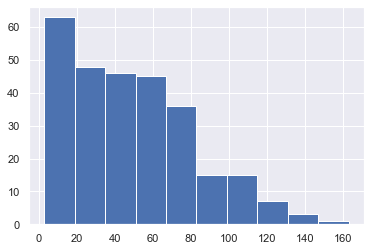

In [52]:
full_sellers['days_to_sale'] = (full_sellers['first_sales_date']-full_sellers['won_date']).astype('timedelta64[D]')
plt.hist(full_sellers['days_to_sale'], bins = 10)
plt.show()

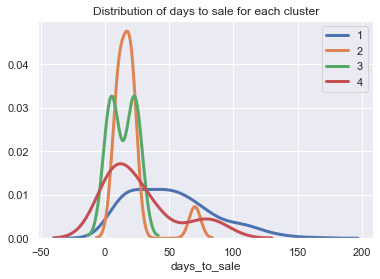

In [53]:
for c in clusters:
    subset = full_sellers[full_sellers['cluster'] == c]
    
    # Draw the density plot
    sns.distplot(subset['days_to_sale'], hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = c)
plt.title("Distribution of days to sale for each cluster")    
plt.savefig('clusters_daystosale.png')

For clusters that have mainly lead types Online_big and online_medium, the days_to_sale seems to be shorter on average. Let's have a look at the correlation matrix and include a few other possible features:

In [54]:
corr_cols = ['lead_type', 'lead_behaviour_profile', 'days_to_sale', 'days_to_close']
corr_df = full_sellers[corr_cols]

corr_df=pd.get_dummies(corr_df, columns=['lead_type', 'lead_behaviour_profile'])

In [55]:
len(full_sellers[full_sellers.days_to_sale < 0])

0

In [56]:
corr_df.corr().style.background_gradient(cmap='coolwarm', axis=None)

,days_to_sale,days_to_close,lead_type_industry,lead_type_offline,lead_type_online_big,lead_type_online_medium,lead_type_online_small,lead_behaviour_profile_cat,lead_behaviour_profile_eagle,lead_behaviour_profile_others,lead_behaviour_profile_shark,lead_behaviour_profile_wolf
days_to_sale,1,-0.164639,-0.0253936,0.104585,-0.151069,0.1141,-0.0382335,-0.0489074,-0.0503384,0.00825079,0.0627824,0.0854127
days_to_close,-0.164639,1,0.0984442,-0.0655959,0.045456,-0.0466608,-0.0260597,-0.118067,-0.0075778,-0.0108087,-0.0139287,0.176117
lead_type_industry,-0.0253936,0.0984442,1,-0.0952888,-0.187764,-0.311976,-0.12233,-0.0932152,0.0652827,-0.0200318,-0.000229989,0.0595408
lead_type_offline,0.104585,-0.0655959,-0.0952888,1,-0.160387,-0.266488,-0.104493,-0.0655192,0.0825426,-0.0171111,0.018074,-0.00612765
lead_type_online_big,-0.151069,0.045456,-0.187764,-0.160387,1,-0.525107,-0.205901,0.0957305,-0.016914,-0.0337169,-0.0181191,-0.095874
lead_type_online_medium,0.1141,-0.0466608,-0.311976,-0.266488,-0.525107,1,-0.342112,-0.0667364,-0.0534688,0.0642095,0.051812,0.109106
lead_type_online_small,-0.0382335,-0.0260597,-0.12233,-0.104493,-0.205901,-0.342112,1,0.116716,-0.0232095,-0.0219668,-0.0706177,-0.09211
lead_behaviour_profile_cat,-0.0489074,-0.118067,-0.0932152,-0.0655192,0.0957305,-0.0667364,0.116716,1,-0.608024,-0.0790067,-0.253986,-0.554545
lead_behaviour_profile_eagle,-0.0503384,-0.0075778,0.0652827,0.0825426,-0.016914,-0.0534688,-0.0232095,-0.608024,1,-0.0276829,-0.0889934,-0.194305
lead_behaviour_profile_others,0.00825079,-0.0108087,-0.0200318,-0.0171111,-0.0337169,0.0642095,-0.0219668,-0.0790067,-0.0276829,1,-0.0115638,-0.0252481


According to the correlation matrix, the lead behaviour profile doesn't really have a correlation with days-to-sale, so we will leave that feature out of the survival analysis. The days-to-close was used in the modeling at first, but the predictive power of the model on the test set was better without it so it is excluded from the features.

In [57]:
print('Data for survival analysis:', len(data_sellers))
print('Datapoints with un-censored event:', len(full_sellers))

Data for survival analysis: 640
Datapoints with un-censored event: 279


In [82]:
#specify "today"
today = orders['date'].max()

#let's create the event column
cols = ['seller_id', 'lead_type', 'won_date', 'days_to_close']
data_survival = data_sellers[cols]
data_survival = data_survival.merge(full_sellers[['seller_id','days_to_sale']], on = 'seller_id', how = 'left')

#new columns
data_survival['today'] = today
data_survival['days_in_system'] = (data_survival.today - data_survival.won_date).astype('timedelta64[D]')
data_survival['has_sales'] = 1

data_survival['has_sales'] = np.where(np.isnan(data_survival.days_to_sale), 0,1)
data_survival['days_to_sale'].fillna(data_survival.days_in_system, inplace = True)

data_survival = data_survival[['lead_type', 'days_to_sale', 'has_sales', 'days_to_close']]

data_survival.head()

,lead_type,days_to_sale,has_sales,days_to_close
0,online_medium,114.0,1,5.0
1,industry,117.0,0,34.0
2,online_big,5.0,1,63.0
3,industry,15.0,1,267.0
4,online_medium,139.0,0,55.0


Because of our definition of "today", we have to exclude some of the sellers who were won after the last order date of the dataset. Then we will define the time and event columns and feature columns.

In [83]:
print('Maximum won date:', data_sellers['won_date'].max())
print('Maximum order date:' , orders['date'].max())
print('Number of sellers won after the last order date:', len(data_survival[data_survival.days_to_sale > 0]) )
data_survival = data_survival[data_survival.days_to_sale > 0]

Maximum won date: 2018-11-06 19:41:39
Maximum order date: 2018-09-03 09:06:57
Number of sellers won after the last order date: 595


In [84]:
# Define the time and event columns
time_column = 'days_to_sale'
event_column = 'has_sales'

In [85]:
dataset = data_survival.copy()
dataset = pd.get_dummies(dataset, columns = ['lead_type'], drop_first=True)

In [86]:
features = np.setdiff1d(dataset.columns, [time_column, event_column]).tolist()

In [87]:
features

['days_to_close',
 'lead_type_offline',
 'lead_type_online_big',
 'lead_type_online_medium',
 'lead_type_online_small']

### Preparations for modeling
To prepare for the modeling part, we will create the train/test-split, standardize the data and import performance metrics

In [88]:
# Build training and test sets
from sklearn.model_selection import train_test_split
N = dataset.shape[0]

index_train, index_test = train_test_split(
    range(N),
    test_size=.3,
)

data_train = dataset.loc[index_train]
data_test = dataset.loc[index_test]

data_train = data_train.dropna()
data_test = data_test.dropna()

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  # Remove the CWD from sys.path while we load stuff.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  # This is added back by InteractiveShellApp.init_path()


In [89]:
# Standardize
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(data_train)

scaler.transform(data_train)
scaler.transform(data_test)

array([[ 0.54445124,  1.14597252, -0.29036676, ..., -0.45973521,
         1.22874079, -0.42179866],
       [-0.64173231,  1.14597252,  0.55087995, ..., -0.45973521,
         1.22874079, -0.42179866],
       [ 0.17266237,  1.14597252,  0.05183529, ..., -0.45973521,
        -0.8138413 , -0.42179866],
       ...,
       [ 0.70378933, -0.87262128, -0.16204099, ..., -0.45973521,
        -0.8138413 , -0.42179866],
       [-1.20826774,  1.14597252, -0.58979355, ..., -0.45973521,
        -0.8138413 , -0.42179866],
       [ 1.11098667, -0.87262128, -0.26184992, ..., -0.45973521,
        -0.8138413 ,  2.37079937]])

In [93]:
X_train, X_test = data_train[features], data_test[features]
T_train, T_test = data_train[time_column], data_test[time_column]
E_train, E_test = data_train[event_column], data_test[event_column]

In [94]:
#Performance metrics
from lifelines.utils import concordance_index
from sklearn.metrics import brier_score_loss

In [95]:
from bokeh.palettes import Category10
# Define colors
colors = []
for i in range(5):
    colors.append(Category10[10][i])

### Survival analysis models
Finally we will do survival analysis with our dataset. Let's first look at a sample of our data to understand what we are modeling. Then we will calculate fit a Kaplan-Meier model to the data, and compare it with an exponential fit. 

//anaconda3/lib/python3.7/site-packages/pandas/core/series.py:942: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


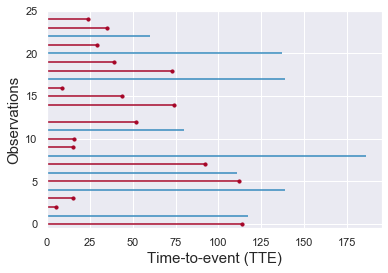

In [96]:
from lifelines.plotting import plot_lifetimes

plot_lifetimes(
    data_survival[time_column][:25],
     event_observed=data_survival[event_column][:25],
)
plt.xlim(0, None)
plt.xlabel('Time-to-event (TTE)', fontsize=15.)
plt.ylabel('Observations', fontsize=15.)
plt.show()

In [97]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(T_train, E_train)


<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 384 total observations, 218 right-censored observations>

In [98]:
from lifelines import ExponentialFitter
exf = ExponentialFitter()
exf.fit(T_train, E_train, label='ExponentalFitter')

<lifelines.ExponentialFitter:"ExponentalFitter", fitted with 384 total observations, 218 right-censored observations>

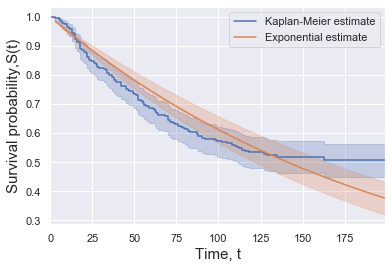

In [99]:
# Plot KM estimate and exponential estimate of the survival function

# Display survival function
ax = kmf.plot_survival_function(label='Kaplan-Meier estimate')
ax = exf.plot_survival_function(label='Exponential estimate')
ax.set_xlabel(
    'Time, t',
    fontsize=15.,
)
ax.set_ylabel(
    'Survival probability,S(t)',
    fontsize=15.,
)
plt.legend()
plt.show()

It seems like the Kaplan-Meier curve converges to about a 0.5 probability, while the exponential curve goes towards zero. With the KaplanMeier model we therefore state that even if it has been 175 days since the seller signed up for Olist, there is still an almost 50% probability that they will get a sale. The exponential model assumes that the probability keeps decreasing over time, which might be more realistic since not having sales might be a result of the seller simply not having a product that the customers would want to buy. Over time the resources of the seller might also be depleted, which could make it difficult for the seller to bring to new products to the site. 

Nonetheless, we will choose the Kaplan-Meier model going forward. It seems to capture the effect better up until 125 days. 

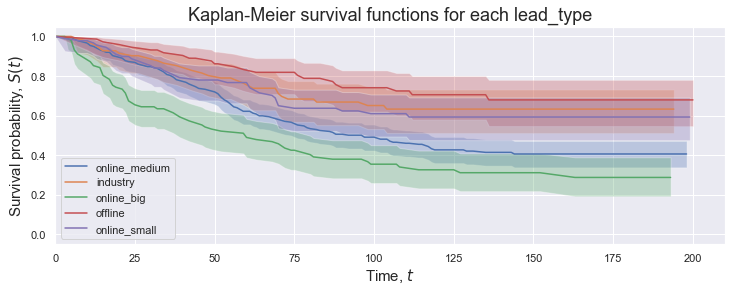

In [100]:
fig, ax = plt.subplots(figsize=(12., 4.))


# Which feature we're looking at
feat = 'lead_type'
feats = data_survival[feat].unique()
    
for i in range(len(feats)):
    value = feats[i]
    # Filter the dataset for specific feature value
    reduced_dataset = data_survival[data_survival[feat] == value]

    # Initialize the Kaplan-Meier model
    km_item = KaplanMeierFitter()
    #km_item = ExponentialFitter()

    # Fit the model
    km_item.fit(
        reduced_dataset[time_column],
        event_observed=reduced_dataset[event_column],
        )

    # Plot survival function
    ax.plot(
        km_item.timeline,
        km_item.survival_function_.to_numpy().flatten(),
        label=value
        )

    #Plot confidence interval
    ax.fill_between(
            km_item.timeline,
            km_item.confidence_interval_['KM_estimate_lower_0.95'].to_numpy(),
            km_item.confidence_interval_['KM_estimate_upper_0.95'].to_numpy(),
            alpha=.3,
        )

ax.set_title(
        'Kaplan-Meier survival functions for each {}'.format(feat),
        fontsize=18.,
    )
ax.set_xlabel(
        'Time, $ t $',
        fontsize=15.,
    )
ax.set_ylabel(
        'Survival probability, $ S(t) $',
        fontsize=15.,
    )
ax.set_xlim(0., None)
ax.set_ylim(-.05, 1.05)
ax.legend()
plt.show()

We can see that the fitted curves are quite different for each lead type. Online_big has the lowest probability for not getting a sale, and offline has the highest probability of not getting a sale. This makes sense, because big online retailers probably already have the platform and the products that buyers want. 

Next we want to see if it's possible to predict survival times. We will use the Cox proportinal hazard's model and try a few different parameters with the help k_fold_cross_validation. On each fold, it splits the data into a training set and a testing set fits itself on the training set and evaluates itself on the testing set (using the concordance measure by default). We will use the training data only, and it's splitted to training and validation sets in the validation. 

In [101]:
from lifelines import CoxPHFitter
from lifelines.utils import k_fold_cross_validation


#create the four models we'd like to compare.
cph_0 = CoxPHFitter(penalizer = 0.1)
cph_1 = CoxPHFitter(penalizer = 0.5)
cph_2 = CoxPHFitter(penalizer = 10)
cph_3 = CoxPHFitter(penalizer = 50)


print(np.mean(k_fold_cross_validation(cph_0, data_train, duration_col=time_column, event_col=event_column, k=5)))
print(np.mean(k_fold_cross_validation(cph_1, data_train, duration_col=time_column, event_col=event_column, k=5)))
print(np.mean(k_fold_cross_validation(cph_2, data_train, duration_col=time_column, event_col=event_column, k=5)))
print(np.mean(k_fold_cross_validation(cph_3, data_train, duration_col=time_column, event_col=event_column, k=5)))


0.5929935833186978
0.5771432926282349
0.5947632176742501
0.5878570252068502


The scores are the mean concordance scores for each model. All of the four models have a very similar score. Because we don't want to overfit to our training data, we'll choose the model with penalizer = 0.1.

In [102]:
#chosen model
model = CoxPHFitter(penalizer = 0.1)

model.fit(
    data_train,
    duration_col=time_column,
    event_col=event_column,
    show_progress=True,
)

Iteration 5: norm_delta = 0.00000, step_size = 1.0000, ll = -910.99079, newton_decrement = 0.00000, seconds_since_start = 0.1Convergence completed after 5 iterations.


<lifelines.CoxPHFitter:"None", fitted with 384 total observations, 218 right-censored observations>

Let's calculate the concordance index for our test and training data, which gives the model’s ability to correctly provide a reliable ranking of the survival times based on the individual risk scores. In general, when the C-index is close to 1, the model has an almost perfect discriminatory power; but when it is close to 0.5, it has no ability to discriminate between low and high risk subjects. It is formulated as:

In [103]:
c_index_train = concordance_index(
    data_train[time_column][E_train.astype(bool)],
    model.predict_expectation(data_train)[E_train.astype(bool)],
)

print('C-index (training) = {}'.format(c_index_train))

C-index (training) = 0.5378452222714518


In [104]:
c_index_test = concordance_index(
    data_test[time_column][E_test.astype(bool)],
    model.predict_expectation(data_test)[E_test.astype(bool)],
)

print('C-index (test) = {}'.format(c_index_test))

C-index (test) = 0.5432377511853692


According to https://lifelines.readthedocs.io/en/latest/Survival%20Regression.html, fitted survival models typically have a concordance index between 0.55 and 0.75 (this may seem bad, but even a perfect model has a lot of noise than can make a high score impossible). Our model is on the lower end of the scale in terms of predictability.

Let's claculate the brier scores as well. The Brier score (BS) measures the average discrepancies between the status and the estimated probabilities at a given time. Thus, the lower the score (usually below 0.25), the better the predictive performance. 

In [105]:
brier_scores = []

for X, T in [
    (
        data_train[features][E_train.astype(bool)],
        data_train[time_column][E_train.astype(bool)],
    ),
    (
        data_test[features][E_test.astype(bool)],
        data_test[time_column][E_test.astype(bool)],
    )]:
    
    brier_score = []

    predictions = model.predict_survival_function(X)
    timeline = predictions.index.to_numpy()

    for t in predictions.index:
        survival = predictions.loc[t]

        y_true_brier = np.array(t < T, dtype=float)

        brier_score.append(brier_score_loss(y_true_brier, survival))
    
    brier_scores.append(np.array(brier_score))

Integrated Brier score (training) = 0.264
Integrated Brier score (test) = 0.25


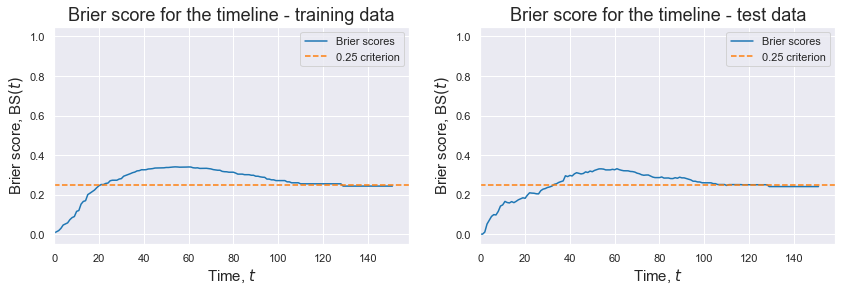

In [106]:
# Plot Brier scores
fig = plt.figure(figsize=(14., 4.))

for idx, score in enumerate(brier_scores):
    ax = fig.add_subplot(1, 2, idx + 1)
    
    label = 'training' if idx == 0 else 'test'
    
    ax.plot(
        score,
        color=colors[0],
        label='Brier scores'
    )
    ax.axhline(
        0.25, 
        color=colors[1], 
        ls='--',
        label='0.25 criterion',
    )
    ax.set_xlim(0., None)
    ax.set_ylim(-.05, 1.05)
    ax.set_title(
        'Brier score for the timeline - {} data'.format(label),
        fontsize=18.,
    )
    ax.set_xlabel(
        'Time, $ t $',
        fontsize=15.,
    )
    ax.set_ylabel(
        'Brier score, BS$ (t) $',
        fontsize=15.,
    )
    ax.legend()
    
    print('Integrated Brier score ({}) = {}'.format(label, np.round(score.mean(), 3)))

plt.show()

The Brier score stays almost below the 0.25. The model has some potential. Let's now compare the Cox proportional hazards model predictions with the Kaplan-Meier estimator.

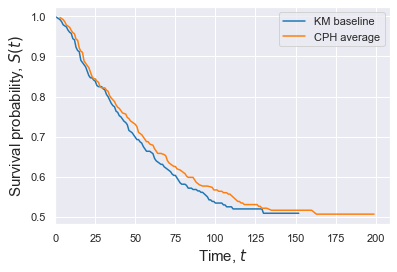

In [107]:
# Compare the baseline survival function obtained via Kaplan-Meier estimator and 
# the average prediction of the Cox proportional hazard models
S = kmf.survival_function_.to_numpy().flatten()

plt.plot(
    S,
    label='KM baseline',
    color=colors[0],
)

plt.plot(
    model.predict_survival_function(X_test).mean(axis=1),
    label='CPH average',
    color=colors[1],
)

plt.xlabel(
    'Time, $ t $',
    fontsize=15.,
)

plt.xlim(0., None)

plt.ylabel(
    'Survival probability, $ S(t) $',
    fontsize=15.,
)
plt.legend()
plt.show()

The prediction of the Cox Proportional Hazards function actually seems to match the Kaplain-Meier curve nicely. Let's look at the predictions for each lead type separately next.

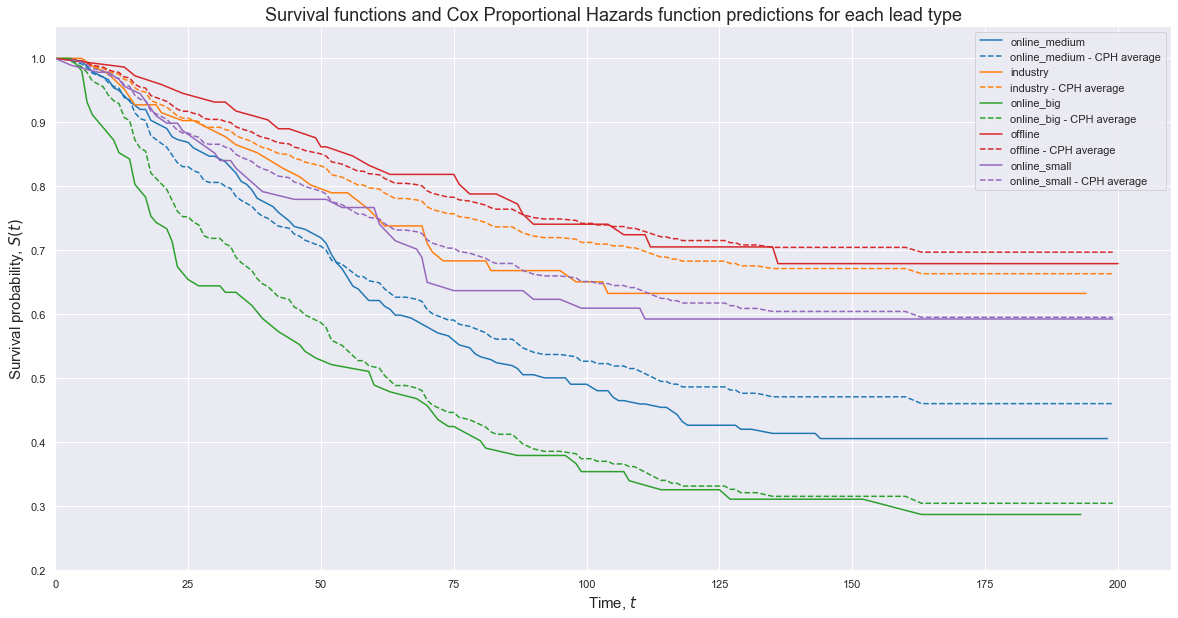

In [108]:
fig, ax = plt.subplots(figsize=(20., 10.))


# Which feature we're looking at
feat = 'lead_type'
feats = data_survival[feat].unique()
    
for i in range(len(feats)):
    value = feats[i]
    # Filter the dataset for specific feature value
    reduced_dataset = data_survival[data_survival[feat] == value]

    # Initialize the Kaplan-Meier model
    km_item = KaplanMeierFitter()

    # Fit the model
    km_item.fit(
        reduced_dataset[time_column],
        event_observed=reduced_dataset[event_column],
        )

    # Plot survival function
    ax.plot(
        km_item.timeline,
        km_item.survival_function_.to_numpy().flatten(),
        label=value,
        color=colors[i],
        )

    # Plot confidence interval
    #ax.fill_between(
    #        km_item.timeline,
    #        km_item.confidence_interval_['KM_estimate_lower_0.95'].to_numpy(),
    #        km_item.confidence_interval_['KM_estimate_upper_0.95'].to_numpy(),
    #        alpha=.3,
    #        color=colors[i],
    #    )
    
    # ***** Cox proportional hazards models predictions *****
    
    indexes = np.intersect1d(reduced_dataset.index.to_numpy(), index_test)
    predictions = model.predict_survival_function(X_test.loc[indexes])
    
    # Plot CPH survival function
    ax.plot(
        predictions.index.to_numpy(),
        predictions.mean(axis=1),
        label='{} - CPH average'.format(value),
        ls='--',
        color=colors[i],
    )    

ax.set_title(
        'Survival functions and Cox Proportional Hazards function predictions for each lead type',
        fontsize=18.,
    )
ax.set_xlabel(
        'Time, $ t $',
        fontsize=15.,
    )
ax.set_ylabel(
        'Survival probability, $ S(t) $',
        fontsize=15.,
    )
ax.set_xlim(0., None)
ax.set_ylim(0.2, 1.05)
ax.legend()
plt.savefig('survival_prediction.png')
plt.show()

The perdictions are the most unreliable in the first 50 days. For the big online leads for example, the probability of no sale drops faster than the probability of the prediction. The curves for small online leads and industry leads are very similar, so those could possibly be combined. All in all, the predictions capture the differences between lead types and could be used for rough estimations. 

## 6. Conclusions and possibilities for further analysis
According to the clustering, Olist should focus on medium to big online sellers with a focused assortment in terms of product categories, but a broad assortment in terms of products. The clustering results could also be used to define pricing categories, and making it easier for new small sellers to get started, since that is the majority of sellers. The survival analysis gave a good insight into the differences in lead types, and confirmed the fact that big online sellers start making sales faster. This curve could also be shown to the leads when they are being targeted in marketing, in order to convince them that the platform is an efficient place to start getting sales.

There are plenty of possibilities for further analysis. If there was more data provided in the lead signup phase, we could make a more accurate estimation of the survival times as well as the future success of the seller. Information like number of categories and number of products could be included. If we had lead data from a longer time period, it would be possible to look at trends in how well the seller is getting up to speed. If there was more data for the leads that didn't sign up in the end, it would be possible to predict whether a deal will close or not. 